<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Reinforcement_Learning_Stock_Trading_Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
<ipython-input-11-f446b8f15752>:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['Open']),
<ipython-input-11-f446b8f15752>:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['High']),
<ipython-input-11-f446b8f15752>:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 3.55e+07 |
| time/              |          |
|    fps             | 370      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1e+03         |
|    ep_rew_mean          | 3.11e+07      |
| time/                   |               |
|    fps                  | 321           |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 2.0547304e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

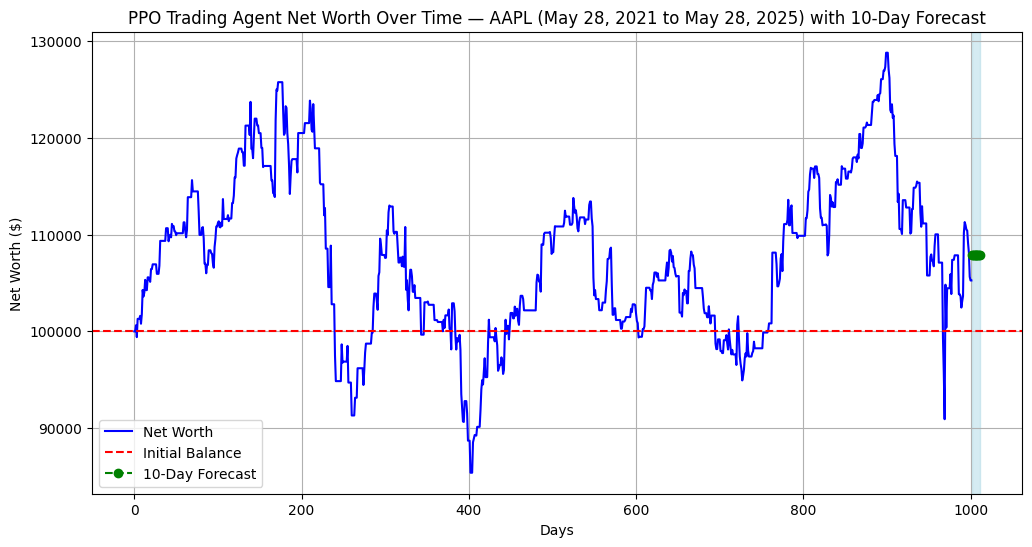

In [11]:
# Install required packages if running locally or in Colab
!pip install yfinance stable-baselines3[extra] shimmy matplotlib numpy pandas gym

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import Env, spaces
from stable_baselines3 import PPO

# Step 1: Download Apple stock data from Yahoo Finance
df = yf.download("AAPL", start="2021-05-28", end="2025-05-28")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Use key price/volume columns only
df.dropna(inplace=True)  # Remove any missing data rows if present
df.reset_index(inplace=True)  # Reset index to have a clean date column

# Step 2: Define Custom Trading Environment (inherits from OpenAI Gym Env)
class AppleTradingEnv(Env):
    def __init__(self, df):
        super().__init__()
        self.df = df  # stock data
        self.n_step = len(df)  # total days in data
        self.current_step = 0  # start from day 0

        self.initial_balance = 100000  # start with $100k
        self.balance = self.initial_balance  # cash in hand
        self.shares_held = 0  # how many shares currently held
        self.net_worth = self.initial_balance  # total value = cash + stock value

        # Action space: Discrete actions - 0: Sell all, 1: Hold, 2: Buy max possible
        self.action_space = spaces.Discrete(3)

        # Observation space: Open, High, Low, Close, Volume, Balance, Shares held
        # All positive values, so low=0, high=infinity, shape=(7,)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(7,), dtype=np.float32)

    def reset(self):
        # Reset the environment to initial state for new episode
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        return self._get_obs()  # return initial observation

    def _get_obs(self):
        # Returns current state observation as numpy array
        row = self.df.iloc[self.current_step]
        obs = [
            float(row['Open']),
            float(row['High']),
            float(row['Low']),
            float(row['Close']),
            float(row['Volume']),
            float(self.balance),
            float(self.shares_held)
        ]
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        # Execute one time step within the environment
        row = self.df.iloc[self.current_step]
        price = float(row['Close'])  # we trade at closing price

        # Perform the action chosen by the agent
        if action == 0:  # Sell all shares
            self.balance += self.shares_held * price
            self.shares_held = 0
        elif action == 2:  # Buy as many shares as possible with available balance
            shares_to_buy = self.balance // price
            self.balance -= shares_to_buy * price
            self.shares_held += shares_to_buy
        # If action == 1, hold: do nothing

        # Update net worth: cash + value of held shares
        self.net_worth = self.balance + self.shares_held * price

        # Move to next day
        self.current_step += 1

        # Check if episode is done (last day)
        done = self.current_step >= self.n_step - 1

        # Reward is change in net worth compared to initial balance
        reward = self.net_worth - self.initial_balance

        # Return next observation, reward, done flag, and empty info
        return self._get_obs(), reward, done, {}

    def render(self):
        # Optional: print current step info
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance}")
        print(f"Shares held: {self.shares_held}")
        print(f"Net worth: {self.net_worth}")

# Step 3: Initialize environment and create PPO agent model
env = AppleTradingEnv(df)
model = PPO("MlpPolicy", env, verbose=1, device="cpu")  # Use CPU for MlpPolicy

# Train PPO agent for 10,000 timesteps
model.learn(total_timesteps=10000)

# Step 4: Evaluate trained agent on environment
obs = env.reset()
net_worths = []  # track net worth each day

for _ in range(env.n_step - 1):
    action, _states = model.predict(obs)  # agent predicts action given observation
    obs, reward, done, _ = env.step(action)  # apply action and get new state
    net_worths.append(env.net_worth)  # record net worth
    if done:
        break

# Step 4.1: Forecast next 10 days by extending data with last row repeated
forecast_steps = 10
last_row = df.iloc[-1]
forecast_df = pd.concat([df, pd.DataFrame([last_row]*forecast_steps)], ignore_index=True)

# Create a new environment for forecasting starting at last known step
class ForecastEnv(AppleTradingEnv):
    def __init__(self, df, start_step):
        super().__init__(df)
        self.current_step = start_step
        self.n_step = len(df)

forecast_env = ForecastEnv(forecast_df, env.n_step - 1)
forecast_env.balance = env.balance
forecast_env.shares_held = env.shares_held
forecast_env.net_worth = env.net_worth

forecast_obs = forecast_env._get_obs()
forecast_net_worths = []

for _ in range(forecast_steps):
    action, _states = model.predict(forecast_obs)
    forecast_obs, reward, done, _ = forecast_env.step(action)
    forecast_net_worths.append(forecast_env.net_worth)

# Step 5: Plot net worth and 10-day forecast
plt.figure(figsize=(12, 6))
plt.plot(net_worths, label="Net Worth", color='blue')
plt.axhline(y=env.initial_balance, color='r', linestyle='--', label="Initial Balance")

forecast_x = range(len(net_worths), len(net_worths) + forecast_steps)

# Light blue shaded area for forecast region (more visible with alpha=0.5)
plt.axvspan(forecast_x.start, forecast_x.stop - 1, color='lightblue', alpha=0.5)

# Green dashed forecast line with circle markers
plt.plot(forecast_x, forecast_net_worths, color='g', linestyle='--', marker='o', label='10-Day Forecast')

plt.title ("PPO Trading Agent Net Worth Over Time — AAPL (May 28, 2021 to May 28, 2025) with 10-Day Forecast")
plt.xlabel("Days")
plt.ylabel("Net Worth ($)")
plt.legend()
plt.grid(True)
plt.show()
